In [1]:
import os
import pickle
import random
import glob
import datetime
import pandas as pd
import numpy as np
import cv2
import pydicom
from tqdm import tqdm
from joblib import delayed, Parallel
import zipfile
from pydicom.filebase import DicomBytesIO
import sys
from PIL import Image



# importing pyplot and image from matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 


from keras.preprocessing import image
import albumentations as A

Using TensorFlow backend.


In [2]:
base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'

In [3]:
train_df = pd.read_csv(f'{base_url}/stage_2_train.csv').drop_duplicates()
train_df['ImageID'] = train_df['ID'].str.slice(stop=12)
train_df['Diagnosis'] = train_df['ID'].str.slice(start=13)
train_labels = train_df.pivot(index="ImageID", columns="Diagnosis", values="Label")
train_labels.head()

Diagnosis,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ImageID,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [4]:
train_metadata = pd.read_parquet(f'{base_url}/train_metadata.parquet.gzip')
test_metadata = pd.read_parquet(f'{base_url}/test_metadata.parquet.gzip')

train_metadata["Dataset"] = "train"
test_metadata["Dataset"] = "test"

train_metadata = train_metadata.join(train_labels)

metadata = pd.concat([train_metadata, test_metadata], sort=True)
metadata.sort_values(by="ImagePositionPatient_2", inplace=True, ascending=False)
metadata.head()

,BitsAllocated,BitsStored,Columns,Dataset,HighBit,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,...,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
Image,,,,,,,,,,,,,,,,,,,,,
ID_24250ffbc,16,12,512,train,11,1.0,0.0,0.0,0.0,0.920505,...,,ID_6222a3935b,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_6e8c8d650,16,12,512,train,11,1.0,0.0,0.0,0.0,0.920505,...,,ID_6222a3935b,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_ac042708d,16,12,512,train,11,1.0,0.0,0.0,0.0,0.920505,...,,ID_6222a3935b,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_d1e2a17a9,16,12,512,train,11,1.0,0.0,0.0,0.0,0.927184,...,,ID_a5fb903898,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_e1a1b45a5,16,12,512,train,11,1.0,0.0,0.0,0.0,0.920505,...,,ID_6222a3935b,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
test_df = metadata[metadata['Dataset'] == 'test'].iloc[:,:-6].drop(['Dataset'], axis= 1)

In [46]:
train_df = metadata[metadata['Dataset'] == 'train'].drop(['Dataset'], axis= 1)

In [47]:
train_df.shape

(752803, 35)

In [48]:
train_y =  train_df[['any','epidural','intraparenchymal','intraventricular', 'subarachnoid','subdural']]
train_y.shape

(752803, 6)

# Generator

In [34]:
from skimage.io import imread
def get_input(path):
    
    img = imread( path )
    
    return( img )

In [167]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications.vgg19 import preprocess_input
def get_output( path, label_file = None ):
    
    img_id = path.split('/')[-1].split('.')[0]
    labels = label_file.loc[img_id].values
    
    return(labels)

In [201]:
def preprocess_input( image ):
    image_size = (224,224)
    transform = A.Compose([
        A.Resize(*image_size),
        A.HorizontalFlip(),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03,p=0.3),
            A.GridDistortion(p=0.2),
            A.OpticalDistortion(distort_limit=2, shift_limit=0.5,p=0.3),
        ], p=0.3),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10,p=0.1),
    ])
    random.seed(42) 
    augmented_image = transform(image=image)['image']
    #image = np.expand_dims(augmented_image, axis=0)
    #image = preprocess_input(image)
    return( augmented_image )

In [202]:
def image_generator(files, label_file, batch_size = 64):
    train_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/png/train/adjacent-brain-cropped/'
    while True:
        # Select files (paths/indices) for the batch
        for index in range(len(files)):
            batch_paths = files[index*batch_size:(index+1)*batch_size]
            batch_input  = []
            batch_output = [] 

            # Read in each input, perform preprocessing and get labels
            for input_path in batch_paths:
                input = get_input( input_path + '.png')
                output = get_output( input_path + '.png',label_file=label_file )

                input = preprocess_input(image=input)
                batch_input += [ input ]
                batch_output += [ output ]
            # Return a tuple of (input, output) to feed the network
            batch_x = np.array( batch_input )
            batch_y = np.array( batch_output )

            yield( batch_x, batch_y )

In [203]:
train_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/png/train/adjacent-brain-cropped/'


In [207]:
train_generator = image_generator(train_df.index, train_y, batch_size = 32)

In [205]:
l = next(train_generator)

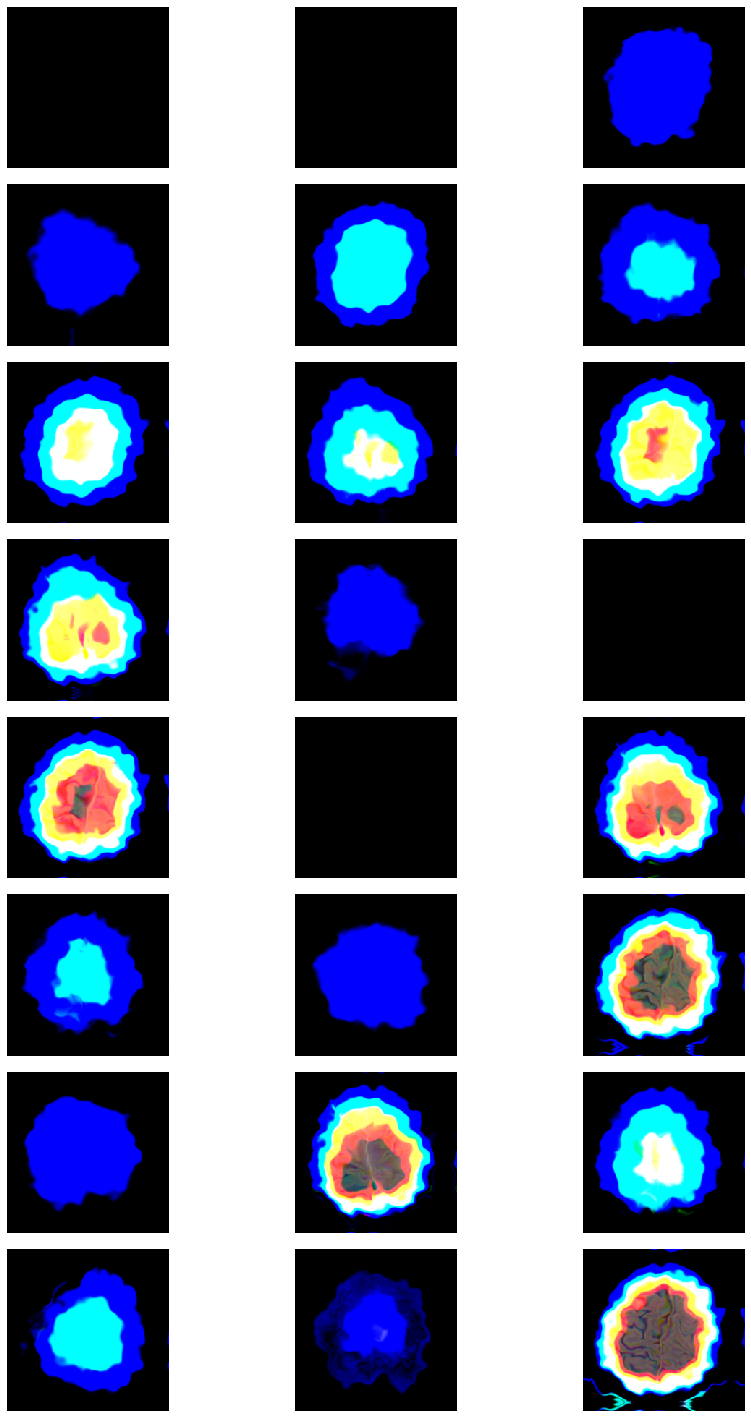

In [206]:
fig = plt.figure(figsize=(15,25))
plt.subplots_adjust(hspace=0.01)
for i,img1 in enumerate(l[0][:24]):           
    plt.subplot(8,3,i+1)
    plt.subplots_adjust(hspace=0.1, wspace = 0.1,bottom =0.1)
    plt.axis("off")
    plt.imshow(l[0][i], cmap = plt.cm.bone)
plt.show()
